In [1]:
import sqlite3
import pandas as pd
import bt
from matplotlib import pyplot as plt
from db import get_all_stock_prices, get_tickers, get_stock, get_pbr


In [11]:
%matplotlib inline

In [2]:
#stock_data.db에 접속
conn = sqlite3.connect('stock_data.db')
cursor = conn.cursor()

In [24]:
# 데이터 로드 (종가 데이터와 PBR 데이터)
prices_df = get_all_stock_prices(conn)

pbr_df = get_pbr(conn)


In [69]:
all_stock_prices = prices_df.copy()
all_stock_prices = all_stock_prices.fillna(method='ffill')

signal_df = pbr_df.copy()

In [97]:
class MyAlgo(bt.Algo):
    def __init__(self, signal_name):
        self.signal_name = signal_name

    def __call__(self, target):
        # Get the signal DataFrame for the current timestamp
        signal = target.get_data(self.signal_name).loc[target.now]

        # Filter out stocks with PBR <= 0
        positive_pbr_stocks = signal[signal > 0]

        # Select the top 20 stocks with the lowest PBR
        top_20_stocks = positive_pbr_stocks.nsmallest(20)

        # Create a boolean Series to select the stocks
        target.temp['selected'] = pd.Series({k: k in top_20_stocks.index for k in target.children})

        return True

In [102]:
strategy = bt.Strategy('s1', [
    bt.algos.SelectAll(),
    
    bt.algos.RunQuarterly(),
    bt.algos.WeighEqually(),
    bt.algos.Rebalance()
])

In [103]:
# Create a backtest and run it
backtest = bt.Backtest(strategy, all_stock_prices)
result = bt.run(backtest)

<Axes: title={'center': 'Low PBR Strategy Backtest'}>

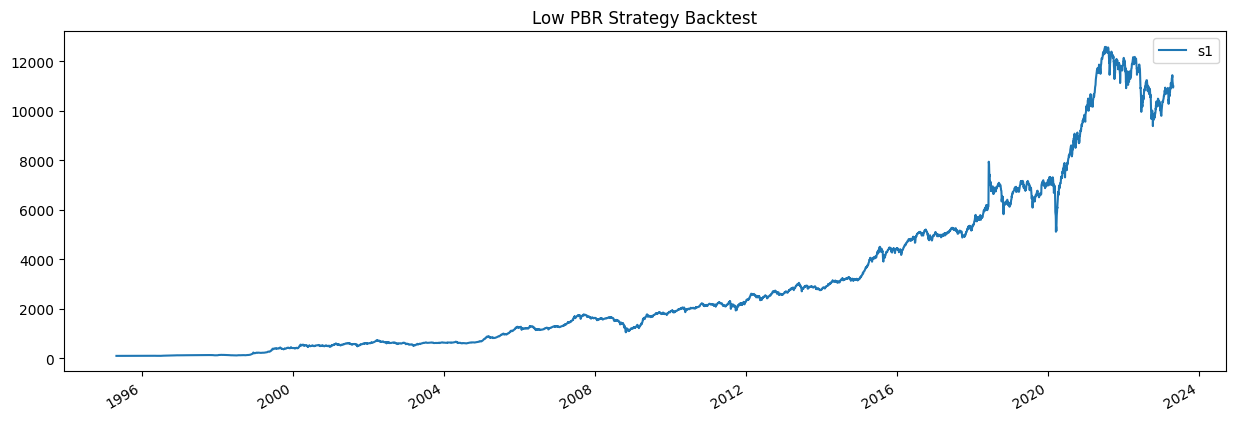

In [104]:
# 백테스트 결과 출력
result.plot(title='Low PBR Strategy Backtest')